# Testing for stability in Event Studies

Hypothesis test of event study coefficients against the constant effect from TWFE. 


### Version 1: Testing equality of adjacent coefficients

In this case, we only estimate the unrestricted model:
$$Y_{it} = \alpha_i + \lambda_t + \sum_{k=1}^K \beta_k D_{k,it} + \varepsilon_{it}$$

And test:
$$H_0: \beta_1 = \beta_2 = ... = \beta_K$$

This can be written as $(K-1)$ restrictions:
$$\beta_1 - \beta_2 = 0$$
$$\beta_2 - \beta_3 = 0$$
$$\vdots$$
$$\beta_{K-1} - \beta_K = 0$$

Where $R$ is a $(K-1) \times K$ matrix:
$$R = \begin{pmatrix}
1 & -1 & 0 & \cdots & 0 \\
0 & 1 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 1 & -1
\end{pmatrix}$$

And $q$ is a $(K-1)$ vector of zeros.

### Version 2: Testing equality to restricted estimate
Here we estimate both models:

- Restricted: 
$$
Y_{it} = \alpha_i + \lambda_t + \beta W_{it} + \varepsilon_{it}
$$

- Unrestricted: 
$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k=1}^K \beta_k D_{k,it} + \varepsilon_{it}
$$

And test:
$$
H_0: \beta_k = \hat{\beta} \text{ for all } k
$$

Where $R$ is a $K \times K$ identity matrix:
$$R = I_K$$

And $q$ is a $K$-vector of the restricted estimate:
$$q = (\hat{\beta}, \hat{\beta}, ..., \hat{\beta})'$$

In both cases, the test statistic is:
$$F = (R\hat{\beta} - q)'[R\hat{V}(\hat{\beta})R']^{-1}(R\hat{\beta} - q)/q$$

Where $\hat{V}(\hat{\beta})$ is the cluster-robust variance-covariance matrix.

In [ ]:
import numpy as np
import pandas as pd
import pyfixest as pf

import matplotlib.pyplot as plt
from lets_plot import *
LetsPlot.setup_html()


## regression estimators for effect dynamics

In [2]:
def diff_in_means(df, T, T0):
    cross_sec_df = (
        df.query(f"time >= {T0}").groupby("unit").agg({"Y": "mean", "W": "max"})
    )
    estimate = pf.feols("Y~W", cross_sec_df).tidy().loc["W", "Estimate"]
    return np.repeat(estimate, T - T0)


def cuped(df, T, T0):
    cross_sec_df = (
        df.query(f"time >= {T0}").groupby("unit").agg({"Y": "mean", "W": "max"})
    )
    cross_sec_df = cross_sec_df.merge(
        df.query(f"time < {T0}").groupby("unit").Y.mean().rename("ldv"),
        left_index=True,
        right_index=True,
    )
    estimate = pf.feols("Y~W+ldv", cross_sec_df).tidy().loc["W", "Estimate"]
    return np.repeat(estimate, T - T0)


def twfe(df, T, T0):
    m = pf.feols("Y~W | unit + time", df).tidy()
    estimate = m.loc["W", "Estimate"]
    return np.repeat(estimate, T - T0)


def panel_diff_in_means(df, T, T0):
    mean_outcomes = df.groupby(["W", "time"])["Y"].mean().unstack()
    diff_means = mean_outcomes.iloc[1, :] - mean_outcomes.iloc[0, :]
    return diff_means[diff_means.notna()].values


def event_study(df, T, T0):
    df["ever_treated"] = df.groupby("unit")["W"].transform("max")
    m = pf.feols(f"Y ~ i(time, ever_treated, ref = {T0-1}) | unit + time", df)
    return m.coef()[(T0 - 1) :].values

In [ ]:
df = df.merge(
      df.assign(first_treated_period=df["time"] * df["treated"])
      .groupby("unit")["first_treated_period"]
      .apply(lambda x: x[x > 0].min()),
      on="unit",
  )
  df["rel_year"] = df["time"] - df["first_treated_period"]
  df["first_treated_period"] = (
      df["first_treated_period"].replace(np.nan, 0).astype("int")
  )
  df["rel_year"] = df["rel_year"].replace(np.nan, np.inf)
  cohort_dummies = pd.get_dummies(
      df.first_treated_period, drop_first=True, prefix="cohort_dummy"
  )
  df_int = pd.concat([df, cohort_dummies], axis=1)
  ff = f"""
              outcome ~
              {'+'.join([f"i(rel_year, {x}, ref = -1.0)" for x in df_int.filter(like = "cohort_dummy", axis = 1).columns])}
              | unit + time
              """
  m3 = pf.feols(ff, df_int, vcov={"CRV1": "unit"})
  res = m3.tidy()
  # create a dict with cohort specific effect curves
  res_dict = {}
  for c in cohort_dummies.columns:
      res_cohort = res.filter(like=c, axis=0)
      event_time = (
          res_cohort.index.str.extract(r"\[T\.(-?\d+\.\d+)\]")
          .astype(float)
          .values.flatten()
      )
      res_dict[c] = {"est": res_cohort, "time": event_time}

In [3]:
def sim_panel(
    base_effect,
    N=1_000_000,
    T=35,
    T0=15,
    sigma_list=[5, 2, 0.01, 2],
    hetfx=False,
    num_treated=None,
    rho=0.7,
    seed=42,
    debug=False,
):
    np.random.seed(seed)
    sigma_unit, sigma_time, sigma_tt, sigma_e = sigma_list
    # Generate data
    unit_ids = np.repeat(np.arange(N), T)
    time_ids = np.tile(np.arange(T), N)
    # Generate unit-specific intercepts and time trends
    unit_fe = np.random.normal(0, sigma_unit, N)
    time_fe = np.random.normal(0, sigma_time, T)
    unit_tt = np.random.normal(0, sigma_tt, N)
    # Generate treatment indicator
    if num_treated is None:
        W = np.random.binomial(1, 0.5, N)
    else:
        treated_units = np.random.choice(N, num_treated, replace=False)
        W = np.zeros(N)
        W[treated_units] = 1
    W = np.repeat(W, T)
    W = W * (time_ids >= T0)
    # Generate treatment effect
    if hetfx:
        unit_effects = np.random.uniform(0.5, 1.5, N)
    else:
        unit_effects = np.ones(N)
    treatment_effect = np.outer(unit_effects, base_effect)
    # Generate serially correlated residuals
    residuals = np.zeros((N, T))
    residuals[:, 0] = np.random.normal(0, sigma_e, N)
    epsilon = np.random.normal(0, 1, (N, T - 1))
    factor = sigma_e * np.sqrt(1 - rho**2)
    for t in range(1, T):
        residuals[:, t] = rho * residuals[:, t - 1] + factor * epsilon[:, t - 1]
    # Generate outcome
    Y = (
        np.repeat(unit_fe, T)
        + np.repeat(unit_tt, T) * time_ids
        + treatment_effect.flatten() * W
        + np.tile(time_fe, N)
        + residuals.flatten()
    )

    # Create DataFrame
    df = pd.DataFrame({"unit": unit_ids, "time": time_ids, "Y": Y, "W": W})
    if debug:
        return Y, W, treatment_effect, df
    return df

In [4]:
def generate_treatment_effect(effect_type, T, T0, max_effect=1):
    if effect_type == "constant":
        return np.concatenate([np.zeros(T0), np.full(T - T0, max_effect)])
    elif effect_type == "linear":
        return np.concatenate([np.zeros(T0), np.linspace(0, max_effect, T - T0)])
    elif effect_type == "concave":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * 0.5 * np.log(2 * np.arange(1, T - T0 + 1) / (T - T0) + 1),
            ]
        )
    elif effect_type == "positive_then_negative":
        half_point = (T - T0) // 2
        return np.concatenate(
            [
                np.zeros(T0),
                np.linspace(0, max_effect, half_point),
                np.linspace(max_effect, -max_effect, T - T0 - half_point),
            ]
        )
    elif effect_type == "exponential":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * (1 - np.exp(-np.linspace(0, 5, T - T0))),
            ]
        )
    elif effect_type == "sinusoidal":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * np.sin(np.linspace(0, 2 * np.pi, T - T0)),
            ]
        )
    elif effect_type == "random_walk":
        return np.concatenate(
            [
                np.zeros(T0),
                max_effect * np.cumsum(np.random.randn(T - T0)),
            ]
        )
    else:
        raise ValueError("Unknown effect type")

In [5]:
# Define the simulation engine
def simulation_engine(
    effect_type, T, T0, max_effect, N, num_treated, sigma_list, hetfx, rho, seed
):
    # Generate true treatment effects
    effect_vector = generate_treatment_effect(effect_type, T, T0, max_effect)
    # Simulate data
    df = sim_panel(
        effect_vector,
        N=N,
        T=T,
        T0=T0,
        sigma_list=sigma_list,
        hetfx=hetfx,
        num_treated=num_treated,
        rho=rho,
        seed=seed,
    )
    # Apply estimators
    estimates = {}
    estimates["true_effect"] = effect_vector[T0:]
    estimators = [diff_in_means, cuped, twfe, panel_diff_in_means, event_study]
    # apply them and add to the estimates dictionary
    for estimator in estimators:
        estimates[estimator.__name__] = estimator(df, T, T0)
    return estimates

Text(0.5, 0.98, 'Static and Dynamic Effects')

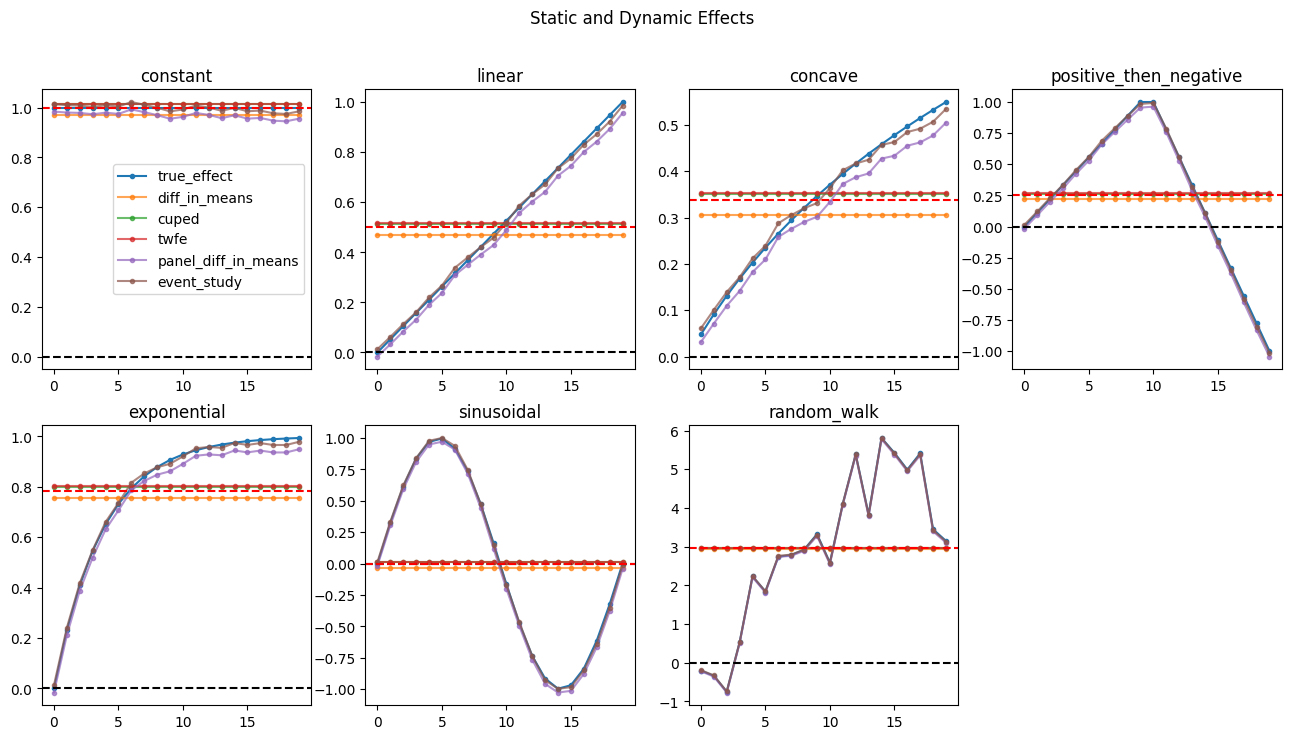

In [ ]:
effect_types = [
    "constant",
    "linear",
    "concave",
    "positive_then_negative",
    "exponential",
    "sinusoidal",
    "random_walk",
]
T, T0 = 35, 15
max_effect = 1
ests = {}
for effect_type in effect_types:
    est = simulation_engine(
        effect_type, T, T0, max_effect, 100_000, 50_000, [5, 2, 0.01, 2],
        False, 0.7, 42
    )
    ests[effect_type] = pd.DataFrame.from_dict(est)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
for k, v, i in zip(ests.keys(), ests.values(), range(7)):
    v[["true_effect"]].plot(
        ax=ax[i // 4, i % 4], marker=".", ms=6, alpha=1, legend=False
    )
    v.drop(["true_effect"], axis=1).plot(
        ax=ax[i // 4, i % 4], marker=".", alpha=0.7, legend=False
    )
    ax[i // 4, i % 4].set_title(k)
    ax[i // 4, i % 4].axhline(0, color="black", linestyle="--")
    ax[i // 4, i % 4].axhline(v.true_effect.mean(), color="red", linestyle="--")
ax[0, 0].legend()
# destroy empty axis
ax[1, 3].axis("off")
f.suptitle("Static and Dynamic Effects")

## F test

In [ ]:
def f_test_stability(df, T0, vcv = {'CRV1':'unit'},
                     dgp_type = "",
                     return_plot = True):
    # Fit models
    df['rel_time'] = df['time'] - (T0) + 1
    df['rel_time'] = df['rel_time'].where(df['W'] == 1, 0)

    restricted = pf.feols("Y ~ i(W) | unit + time", df)
    unrestricted = pf.feols("Y ~ i(rel_time, ref=0) | unit + time", df,
                           vcov=vcv)
    # Get the restricted estimate
    restricted_effect = restricted.coef().iloc[0]
    # Create R matrix - each row tests one event study coefficient
    # against restricted estimate
    n_evstudy_coefs = unrestricted.coef().shape[0]
    R = np.eye(n_evstudy_coefs)
    # q vector is the restricted estimate repeated
    q = np.repeat(restricted_effect, n_evstudy_coefs)
    # Conduct Wald test
    pv = unrestricted.wald_test(R=R, q=q, distribution="chi2")['pvalue']
    if not return_plot:
        return pv
    plotout = (pf.iplot(
        [restricted, unrestricted], coord_flip=False, figsize=(900, 400)
    ) + labs(
        title=f"{dgp_type}",
        subtitle=f"Stability Test p-value ={pv:.3f}",
        x="",
        y="",
        )
    )
    return plotout

In [8]:
effect_types = [
    "constant",
    "linear",
    "concave",
    "positive_then_negative",
    "exponential",
    "sinusoidal",
    "random_walk",
]
N, num_treated, sigma_list, hetfx, rho, seed =  (50_000, 25_000, [5, 2, 0.01, 2],
                                                 False, 0.7, 42)
T, T0 = 35, 15
max_effect = 0.1

for effect_type in effect_types:
    effect_vector = generate_treatment_effect(effect_type, T, T0, max_effect)
    # Simulate data
    df = sim_panel(
        effect_vector,
        N=N,
        T=T,
        T0=T0,
        sigma_list=sigma_list,
        hetfx=hetfx,
        num_treated=num_treated,
        rho=rho,
        seed=seed,
    )
    f_test_stability(df, T0, dgp_type = effect_type).show()

## simulations

In [ ]:
from joblib import Parallel, delayed

def run_single_simulation(effect_type, T, T0, max_effect, N, num_treated,
                         sigma_list, hetfx, rho, seed):
    # Generate treatment effect vector
    effect_vector = generate_treatment_effect(effect_type, T, T0, max_effect)

    # Simulate data
    df = sim_panel(
        effect_vector,
        N=N,
        T=T,
        T0=T0,
        sigma_list=sigma_list,
        hetfx=hetfx,
        num_treated=num_treated,
        rho=rho,
        seed=seed,
    )

    # Run stability test and return p-value
    return f_test_stability(df, T0, return_plot=False)

In [ ]:
def compute_power(n_sims=1000, n_jobs=-1):
    effect_types = [
        "constant",
        "linear",
        "concave",
        "positive_then_negative",
        "exponential",
        "sinusoidal",
        "random_walk",
    ]

    base_params = {
        'N': 50_000,
        'num_treated': 25_000,
        'sigma_list': [5, 2, 0.01, 2],
        'hetfx': False,
        'rho': 0.7,
        'T': 35,
        'T0': 15,
        'max_effect': 0.1
    }

    results = {}
    for effect_type in effect_types:
        # Run parallel simulations
        p_values = Parallel(n_jobs=n_jobs)(
            delayed(run_single_simulation)(
                effect_type=effect_type,
                seed=i,  # Use iteration as seed
                **base_params
            )
            for i in range(n_sims)
        )

        # Compute rejection rate at 5% level
        power = np.mean(np.array(p_values) < 0.05)
        results[effect_type] = {
            'power': power,
            'p_values': p_values
        }

    return results

In [37]:
# Run simulations
results = compute_power(n_sims=1000)

# Print power for each DGP
for effect_type, result in results.items():
    print(f"{effect_type}: {result['power']:.3f}")

constant: 0.043
linear: 0.747
concave: 0.182
positive_then_negative: 1.000
exponential: 0.841
sinusoidal: 1.000
random_walk: 1.000


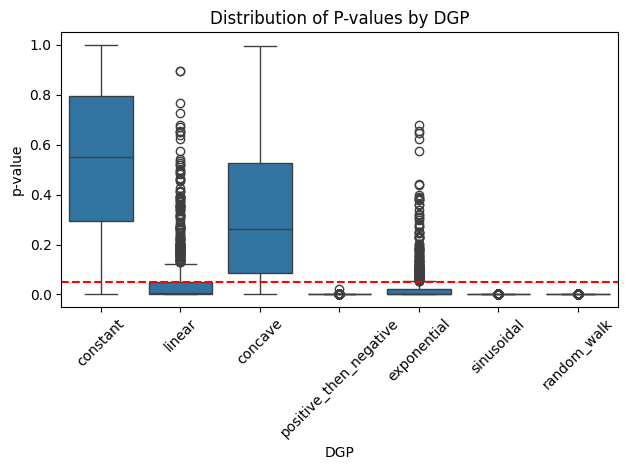

In [ ]:
import seaborn as sns
pvals_df = pd.DataFrame({
    k: result['p_values']
    for k, result in results.items()
}).melt(var_name='DGP', value_name='p-value')

sns.boxplot(data=pvals_df, x='DGP', y='p-value')
plt.xticks(rotation=45)
plt.axhline(0.05, color='red', linestyle='--')
plt.title('Distribution of P-values by DGP')
plt.tight_layout()
plt.show()

- Rejection rate for constant effects is below $\alpha$ : good
- Low power to reject for concave (probably fine since the upper bound is low anyway)
- Solid power for pretty much everything else

### permutation testing (wip)

intuition: if treatment effects are stable, permuting the time label (in the experiment window) shouldn't affect my dynamic treatment effects estimates. 

In [ ]:
from joblib import Parallel, delayed

def _run_single_permutation(df, T0, vcov, restricted_effect):
    df_perm = df.copy()

    # Only permute within treated units
    treated_units = df_perm['unit'].unique()[df_perm.groupby('unit')['W'].max() == 1]

    # For each treated unit, permute their post-treatment times
    for unit in treated_units:
        unit_mask = (df_perm['unit'] == unit) & (df_perm['time'] >= T0)
        post_times = df_perm.loc[unit_mask, 'time'].values
        df_perm.loc[unit_mask, 'time'] = np.random.permutation(post_times)

    # Recompute rel_time
    df_perm['rel_time'] = df_perm['time'] - (T0) + 1
    df_perm['rel_time'] = df_perm['rel_time'].where(df_perm['W'] == 1, 0)

    # Estimate permuted model
    perm_unrestricted = pf.feols("Y ~ i(rel_time, ref=0) | unit + time",
                               df_perm, vcov=vcov)

    # Compute test statistic
    return np.sum((perm_unrestricted.coef() - restricted_effect)**2)

def permutation_test_stability(df, T0, vcov={'CRV1': 'unit'},
                             dgp_type="", n_permutations=1000,
                             return_plot=True, n_jobs=-1):
    # Set up models
    df['rel_time'] = df['time'] - (T0) + 1
    df['rel_time'] = df['rel_time'].where(df['W'] == 1, 0)

    restricted = pf.feols("Y ~ i(W) | unit + time", df)
    unrestricted = pf.feols("Y ~ i(rel_time, ref=0) | unit + time", df, vcov=vcov)

    # Get restricted estimate
    restricted_effect = restricted.coef().iloc[0]

    # Original test statistic
    orig_stat = np.sum((unrestricted.coef() - restricted_effect)**2)

    # Run permutations in parallel
    perm_stats = Parallel(n_jobs=n_jobs)(
        delayed(_run_single_permutation)(df, T0, vcov, restricted_effect)
        for _ in range(n_permutations)
    )

    # Compute p-value
    p_value = np.mean(np.array(perm_stats) >= orig_stat)

    if not return_plot:
        return p_value

    plotout = (pf.iplot(
        [restricted, unrestricted], coord_flip=False, figsize=(900, 400)
    ) + labs(
        title=f"{dgp_type}",
        subtitle=f"Permutation Test p-value ={p_value:.3f}",
        x="",
        y="",
    ))

    return plotout